In [1]:
from ISLP import load_data
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [79]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor as DTR, plot_tree
from ISLP.bart import BART 

In [4]:
carseats_df = load_data("Carseats")
carseats_df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [44]:
carseats_processed = col_trans = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False), ["ShelveLoc", "Urban", "US"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas").fit_transform(carseats_df)

## a)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    carseats_processed.drop("Sales", axis=1), carseats_processed["Sales"], test_size=0.25
)

## b)

In [47]:
dtr = DTR(random_state=0)

dtr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

[Text(0.5795119625520111, 0.9666666666666667, 'ShelveLoc_Good <= 0.5\nsquared_error = 7.537\nsamples = 300\nvalue = 7.679'),
 Text(0.262060072815534, 0.9, 'Population <= 96.5\nsquared_error = 5.952\nsamples = 236\nvalue = 7.03'),
 Text(0.08101811719833564, 0.8333333333333334, 'CompPrice <= 57.0\nsquared_error = 4.548\nsamples = 53\nvalue = 9.051'),
 Text(0.02565880721220527, 0.7666666666666667, 'ShelveLoc_Bad <= 0.5\nsquared_error = 3.041\nsamples = 14\nvalue = 7.406'),
 Text(0.013869625520110958, 0.7, 'Income <= 5.0\nsquared_error = 0.715\nsamples = 6\nvalue = 8.848'),
 Text(0.008321775312066574, 0.6333333333333333, 'Age <= 16.0\nsquared_error = 0.21\nsamples = 3\nvalue = 8.103'),
 Text(0.005547850208044383, 0.5666666666666667, 'Price <= 66.0\nsquared_error = 0.065\nsamples = 2\nvalue = 7.815'),
 Text(0.0027739251040221915, 0.5, 'squared_error = 0.0\nsamples = 1\nvalue = 7.56'),
 Text(0.008321775312066574, 0.5, 'squared_error = 0.0\nsamples = 1\nvalue = 8.07'),
 Text(0.011095700416088

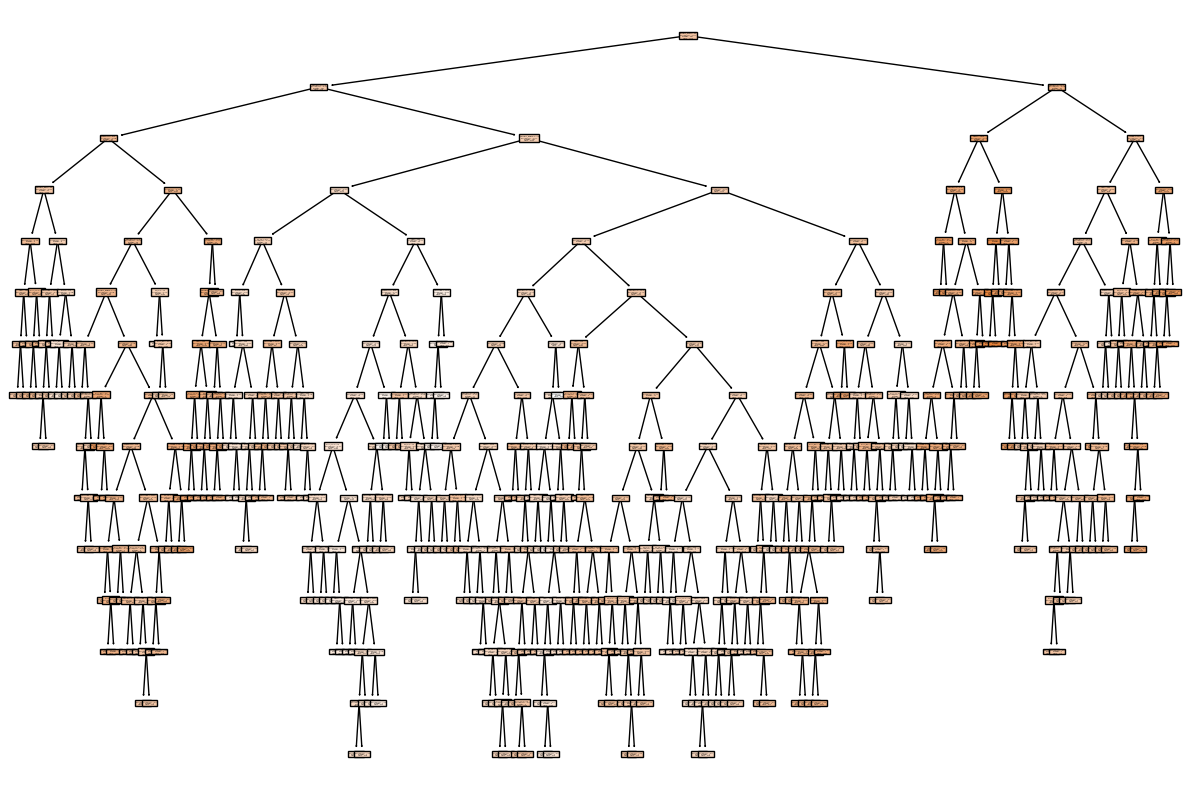

In [49]:
ax = plt.subplots(figsize=(15,10))[1]
plot_tree(dtr, feature_names=carseats_processed.columns, filled=True, ax=ax)

In [51]:
mean_squared_error(y_test, dtr.predict(X_test))

5.2704629999999995

## c)

In [54]:
ccp_path = dtr.cost_complexity_pruning_path(X_train, y_train)
Kfold = KFold(
    n_splits=10, shuffle=True, random_state=1
)

In [58]:
grid = GridSearchCV(
    dtr,
    param_grid={"ccp_alpha": ccp_path.ccp_alphas},
    cv=Kfold,
    scoring="neg_mean_squared_error",
    refit=True,
)
grid.fit(X_train, y_train)
grid.best_score_

-4.713549013811592

[Text(0.5583333333333333, 0.9285714285714286, 'ShelveLoc_Good <= 0.5\nsquared_error = 7.537\nsamples = 300\nvalue = 7.679'),
 Text(0.31666666666666665, 0.7857142857142857, 'Population <= 96.5\nsquared_error = 5.952\nsamples = 236\nvalue = 7.03'),
 Text(0.13333333333333333, 0.6428571428571429, 'CompPrice <= 57.0\nsquared_error = 4.548\nsamples = 53\nvalue = 9.051'),
 Text(0.06666666666666667, 0.5, 'squared_error = 3.041\nsamples = 14\nvalue = 7.406'),
 Text(0.2, 0.5, 'squared_error = 3.771\nsamples = 39\nvalue = 9.641'),
 Text(0.5, 0.6428571428571429, 'ShelveLoc_Medium <= 0.5\nsquared_error = 4.834\nsamples = 183\nvalue = 6.445'),
 Text(0.3333333333333333, 0.5, 'Price <= 42.5\nsquared_error = 3.913\nsamples = 52\nvalue = 5.013'),
 Text(0.26666666666666666, 0.35714285714285715, 'US_Yes <= 0.5\nsquared_error = 4.154\nsamples = 19\nvalue = 6.253'),
 Text(0.2, 0.21428571428571427, 'squared_error = 1.587\nsamples = 8\nvalue = 4.689'),
 Text(0.3333333333333333, 0.21428571428571427, 'squared_e

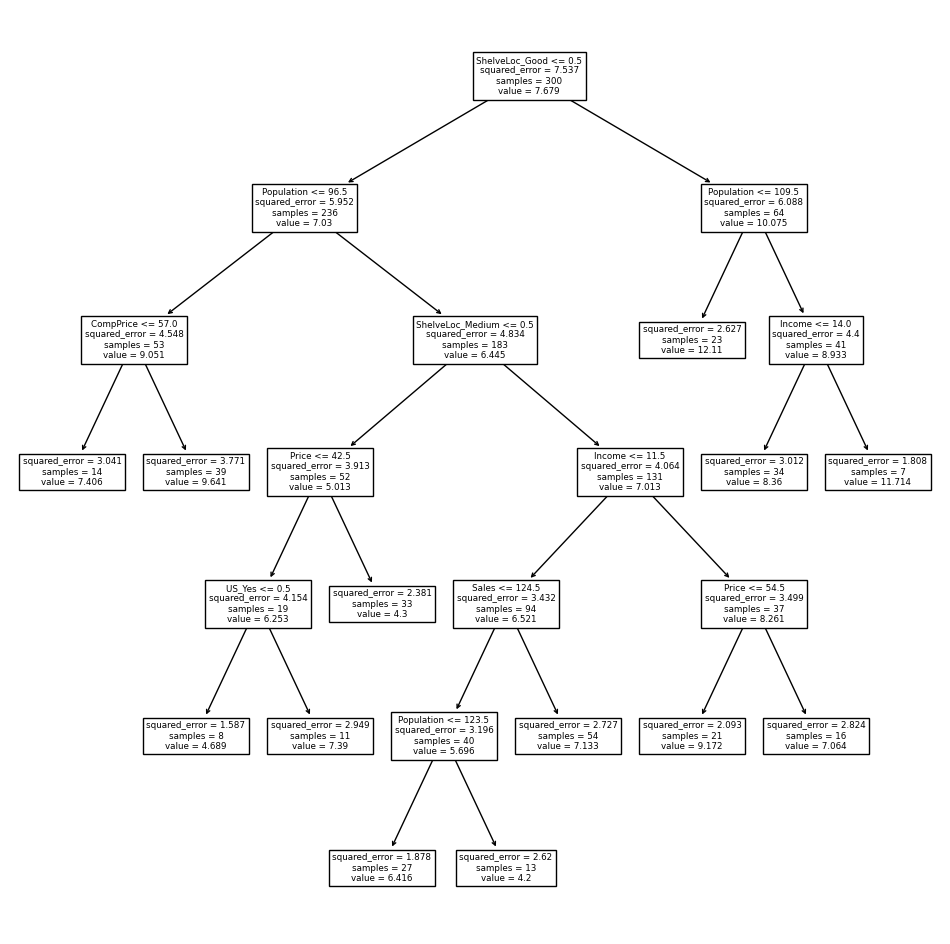

In [61]:
ax = plt.subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(
    best_,
    feature_names=carseats_processed.columns,
    ax=ax,
)

## d)

In [69]:
bag_model = BaggingRegressor(
    DTR(random_state=0), n_estimators=100, max_samples=0.5, bootstrap=True, random_state=0
)

bag_model.fit(X_train, y_train)


BaggingRegressor(estimator=DecisionTreeRegressor(random_state=0),
                 max_samples=0.5, n_estimators=100, random_state=0)

In [70]:
mean_squared_error(y_test, bag_model.predict(X_test))

2.7845838692999987

## e)

In [78]:
max_features_list = [3, 5, 8, 10]

for max_features in max_features_list:
    rf_model = RandomForestRegressor(random_state=0, max_features=max_features)

    rf_model.fit(X_train, y_train)

    mse = mean_squared_error(y_test, rf_model.predict(X_test))
    print(f"number of max features: {max_features}: {mse}")

number of max features: 3: 3.6486260589
number of max features: 5: 3.073752611699999
number of max features: 8: 2.787341490300002
number of max features: 10: 2.7185212678999995
